##Лабораторная 1, вариант 9
# Бинарный классификатор

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [549]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [550]:
df.shape

(253680, 22)

In [551]:
#Пропусков нет
df.isnull().sum()/df.shape[0]

Diabetes_012            0.0
HighBP                  0.0
HighChol                0.0
CholCheck               0.0
BMI                     0.0
Smoker                  0.0
Stroke                  0.0
HeartDiseaseorAttack    0.0
PhysActivity            0.0
Fruits                  0.0
Veggies                 0.0
HvyAlcoholConsump       0.0
AnyHealthcare           0.0
NoDocbcCost             0.0
GenHlth                 0.0
MentHlth                0.0
PhysHlth                0.0
DiffWalk                0.0
Sex                     0.0
Age                     0.0
Education               0.0
Income                  0.0
dtype: float64

In [552]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [553]:
df['Diabetes_012'] = df['Diabetes_012'].replace({2 : 1})

In [554]:
df1 = df.drop_duplicates()

In [555]:
df1.shape

(229712, 22)

# Base Model

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [556]:
X_train, X_rem, y_train, y_rem = train_test_split(df1.drop(['Diabetes_012'], axis=1), df1['Diabetes_012'],
                                                   train_size=0.7, random_state=77)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.66, random_state=77)

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:
1. 4 нейрона, функция активации - ReLU
2. 1 нейрон, функция активации - Sigmoid

In [557]:
binary_classifier = Sequential(
    [
        layers.Dense(4, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 4)                 88        
                                                                 
 dense_159 (Dense)           (None, 1)                 5         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [558]:
binary_classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [559]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('cancer_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [560]:
binary_class_history = binary_classifier.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
16077/16080 [============================>.] - ETA: 0s - loss: 0.4008 - accuracy: 0.8282
Epoch 1: val_accuracy improved from -inf to 0.83158, saving model to cancer_weights-01-0.832.hdf5
16080/16080 [==============================] - 36s 2ms/step - loss: 0.4008 - accuracy: 0.8282 - val_loss: 0.3845 - val_accuracy: 0.8316
Epoch 2/100
   98/16080 [..............................] - ETA: 25s - loss: 0.3513 - accuracy: 0.8582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16063/16080 [============================>.] - ETA: 0s - loss: 0.3855 - accuracy: 0.8305
Epoch 2: val_accuracy improved from 0.83158 to 0.83466, saving model to cancer_weights-02-0.835.hdf5
16080/16080 [==============================] - 33s 2ms/step - loss: 0.3855 - accuracy: 0.8305 - val_loss: 0.3795 - val_accuracy: 0.8347
Epoch 3/100
16050/16080 [============================>.] - ETA: 0s - loss: 0.3813 - accuracy: 0.8319
Epoch 3: val_accuracy improved from 0.83466 to 0.83504, saving model to cancer_weights-03-0.835.hdf5
16080/16080 [==============================] - 33s 2ms/step - loss: 0.3813 - accuracy: 0.8320 - val_loss: 0.3777 - val_accuracy: 0.8350
Epoch 4/100
16051/16080 [============================>.] - ETA: 0s - loss: 0.3781 - accuracy: 0.8331
Epoch 4: val_accuracy did not improve from 0.83504
16080/16080 [==============================] - 32s 2ms/step - loss: 0.3781 - accuracy: 0.8331 - val_loss: 0.3729 - val_accuracy: 0.8350
Epoch 5/100
16055/16080 [=======================

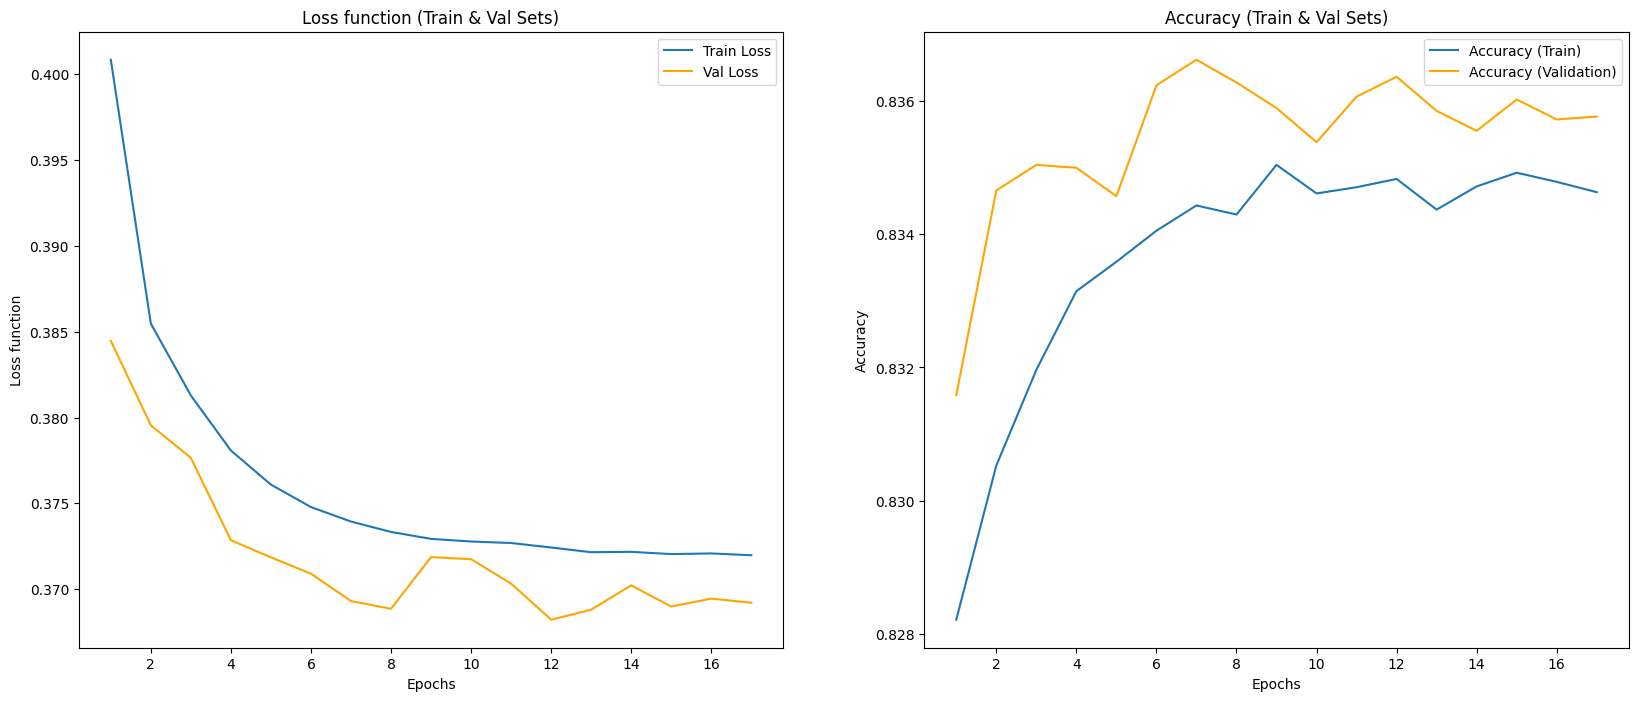

In [561]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [562]:
probs = binary_classifier.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 2s 1ms/step


In [563]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [564]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
print(recall, precision, weighted_accuracy, auc)

0.1612 0.5899 0.5692 0.8


#### Second Model

Во второй модели увеличим количество слоёв, не увиличивая число нейронов и чередуя функции активации:
1. 4 нейрона, ReLU
2. 4 нейрона, Sigmoid
3. 4 нейрона, ReLU
4. 4 нейрона, Sigmoid
5. 2 нейрона, ReLU
6. 1 нейрон, Sigmoid

In [565]:
binary_classifier_2 = Sequential(
    [
        layers.Dense(4, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(4, activation = 'sigmoid'),
        layers.Dense(4, activation = 'relu'),
        layers.Dense(4, activation = 'sigmoid'),
        layers.Dense(2, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier_2.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 4)                 88        
                                                                 
 dense_161 (Dense)           (None, 4)                 20        
                                                                 
 dense_162 (Dense)           (None, 4)                 20        
                                                                 
 dense_163 (Dense)           (None, 4)                 20        
                                                                 
 dense_164 (Dense)           (None, 2)                 10        
                                                                 
 dense_165 (Dense)           (None, 1)                 3         
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161

In [566]:
binary_classifier_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [567]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('cancer2_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [568]:
binary_class_history = binary_classifier_2.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
16072/16080 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8252
Epoch 1: val_accuracy improved from -inf to 0.82821, saving model to cancer2_weights-01-0.828.hdf5
16080/16080 [==============================] - 40s 2ms/step - loss: 0.3974 - accuracy: 0.8252 - val_loss: 0.3747 - val_accuracy: 0.8282
Epoch 2/100
   87/16080 [..............................] - ETA: 28s - loss: 0.3926 - accuracy: 0.8161

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16054/16080 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8314
Epoch 2: val_accuracy improved from 0.82821 to 0.83636, saving model to cancer2_weights-02-0.836.hdf5
16080/16080 [==============================] - 36s 2ms/step - loss: 0.3752 - accuracy: 0.8315 - val_loss: 0.3698 - val_accuracy: 0.8364
Epoch 3/100
16078/16080 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.8338
Epoch 3: val_accuracy did not improve from 0.83636
16080/16080 [==============================] - 38s 2ms/step - loss: 0.3727 - accuracy: 0.8338 - val_loss: 0.3719 - val_accuracy: 0.8356
Epoch 4/100
16055/16080 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8342
Epoch 4: val_accuracy did not improve from 0.83636
16080/16080 [==============================] - 36s 2ms/step - loss: 0.3720 - accuracy: 0.8342 - val_loss: 0.3702 - val_accuracy: 0.8362
Epoch 5/100
16060/16080 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8

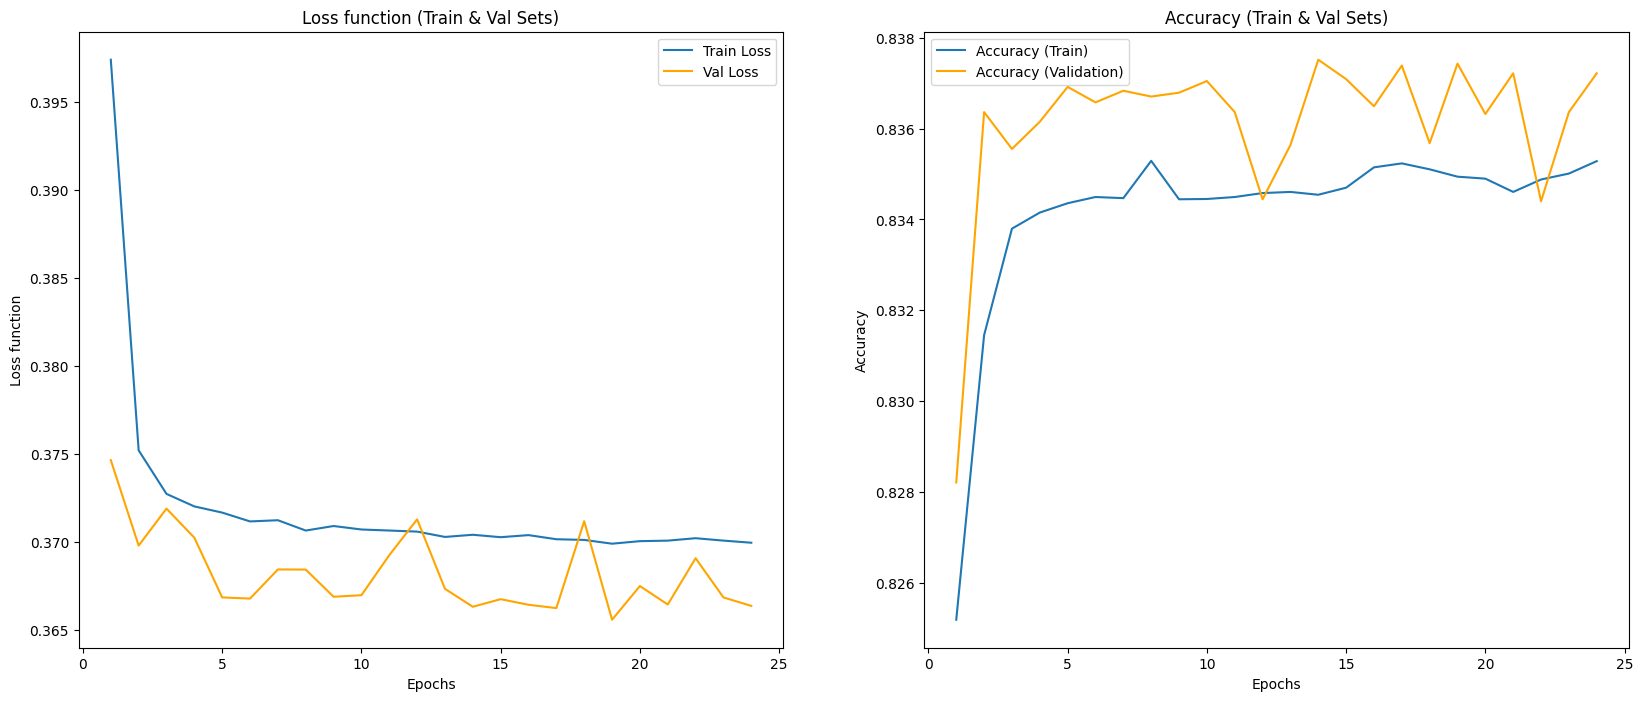

In [569]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [570]:
probs = binary_classifier_2.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 2s 1ms/step


In [571]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [572]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
print(recall, precision, weighted_accuracy,auc)

0.1675 0.591 0.572 0.8039


#### Third Model

Увеличим количество нейронов на каждом слое, кроме последнего:
1. 64 нейрона, ReLU
2. 64 нейрона, Sigmoid
3. 32 нейрона, ReLU
4. 16 нейронов, Sigmoid
5. 8 нейронов, ReLU
6. 1 нейрон, Sigmoid

In [573]:
binary_classifier_3 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier_3.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 64)                1408      
                                                                 
 dense_167 (Dense)           (None, 64)                4160      
                                                                 
 dense_168 (Dense)           (None, 32)                2080      
                                                                 
 dense_169 (Dense)           (None, 16)                528       
                                                                 
 dense_170 (Dense)           (None, 8)                 136       
                                                                 
 dense_171 (Dense)           (None, 1)                 9         
                                                                 
Total params: 8321 (32.50 KB)
Trainable params: 8321 

In [574]:
binary_classifier_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [575]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('cancer3_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

Увеличим число объектов в одном батче в 10 раз и уменьшим количество эпох в 2 раза:

In [576]:
binary_class_history = binary_classifier_3.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 50)

Epoch 1/50
1604/1608 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8293
Epoch 1: val_accuracy improved from -inf to 0.83585, saving model to cancer3_weights-01-0.836.hdf5
1608/1608 [==============================] - 7s 4ms/step - loss: 0.3910 - accuracy: 0.8293 - val_loss: 0.3744 - val_accuracy: 0.8359
Epoch 2/50
  74/1608 [>.............................] - ETA: 3s - loss: 0.3742 - accuracy: 0.8369

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1604/1608 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8343
Epoch 2: val_accuracy improved from 0.83585 to 0.83632, saving model to cancer3_weights-02-0.836.hdf5
1608/1608 [==============================] - 4s 2ms/step - loss: 0.3739 - accuracy: 0.8343 - val_loss: 0.3680 - val_accuracy: 0.8363
Epoch 3/50
1594/1608 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8347
Epoch 3: val_accuracy improved from 0.83632 to 0.83658, saving model to cancer3_weights-03-0.837.hdf5
1608/1608 [==============================] - 4s 2ms/step - loss: 0.3721 - accuracy: 0.8348 - val_loss: 0.3663 - val_accuracy: 0.8366
Epoch 4/50
1598/1608 [============================>.] - ETA: 0s - loss: 0.3711 - accuracy: 0.8351
Epoch 4: val_accuracy did not improve from 0.83658
1608/1608 [==============================] - 4s 3ms/step - loss: 0.3712 - accuracy: 0.8352 - val_loss: 0.3676 - val_accuracy: 0.8354
Epoch 5/50
1605/1608 [============================>.] - ETA: 0s

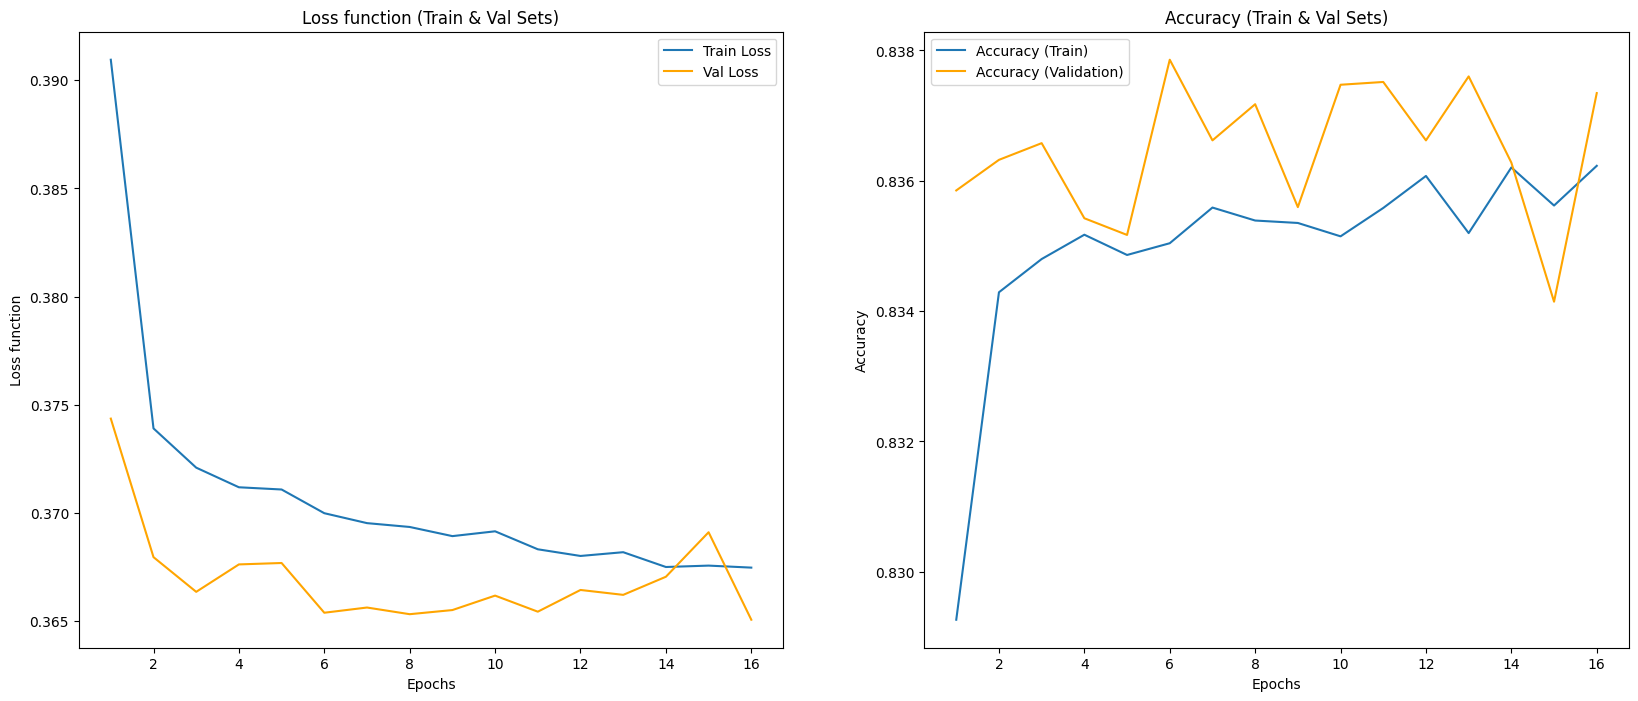

In [577]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [578]:
probs = binary_classifier_3.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 2s 1ms/step


In [579]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [580]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
print(recall, precision, weighted_accuracy,auc)

0.204 0.5599 0.5857 0.8045


#### Fourth Model

Добавим Dropout(0.1) после нескольких первых слоёв:

In [581]:
binary_classifier_4 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dropout(0.1),
        layers.Dense(32, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid')
    ]
)
binary_classifier_4.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 64)                1408      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_173 (Dense)           (None, 64)                4160      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_174 (Dense)           (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_175 (Dense)           (None, 16)              

Процедура оптимизации SGD:

In [582]:
binary_classifier_4.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = 'accuracy')

In [583]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('cancer4_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [584]:
binary_class_history = binary_classifier_4.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 50)

Epoch 1/50
1590/1608 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.8195
Epoch 1: val_accuracy improved from -inf to 0.82663, saving model to cancer4_weights-01-0.827.hdf5
1608/1608 [==============================] - 5s 3ms/step - loss: 0.4667 - accuracy: 0.8195 - val_loss: 0.4550 - val_accuracy: 0.8266
Epoch 2/50
  55/1608 [>.............................] - ETA: 4s - loss: 0.4526 - accuracy: 0.8300

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1606/1608 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.8264
Epoch 2: val_accuracy did not improve from 0.82663
1608/1608 [==============================] - 5s 3ms/step - loss: 0.4538 - accuracy: 0.8264 - val_loss: 0.4458 - val_accuracy: 0.8266
Epoch 3/50
1603/1608 [============================>.] - ETA: 0s - loss: 0.4441 - accuracy: 0.8263
Epoch 3: val_accuracy did not improve from 0.82663
1608/1608 [==============================] - 4s 2ms/step - loss: 0.4440 - accuracy: 0.8264 - val_loss: 0.4310 - val_accuracy: 0.8266
Epoch 4/50
1601/1608 [============================>.] - ETA: 0s - loss: 0.4307 - accuracy: 0.8264
Epoch 4: val_accuracy did not improve from 0.82663
1608/1608 [==============================] - 4s 3ms/step - loss: 0.4308 - accuracy: 0.8264 - val_loss: 0.4174 - val_accuracy: 0.8266
Epoch 5/50
1600/1608 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8264
Epoch 5: val_accuracy did not improve from 0.82663
1608/1608 [=====

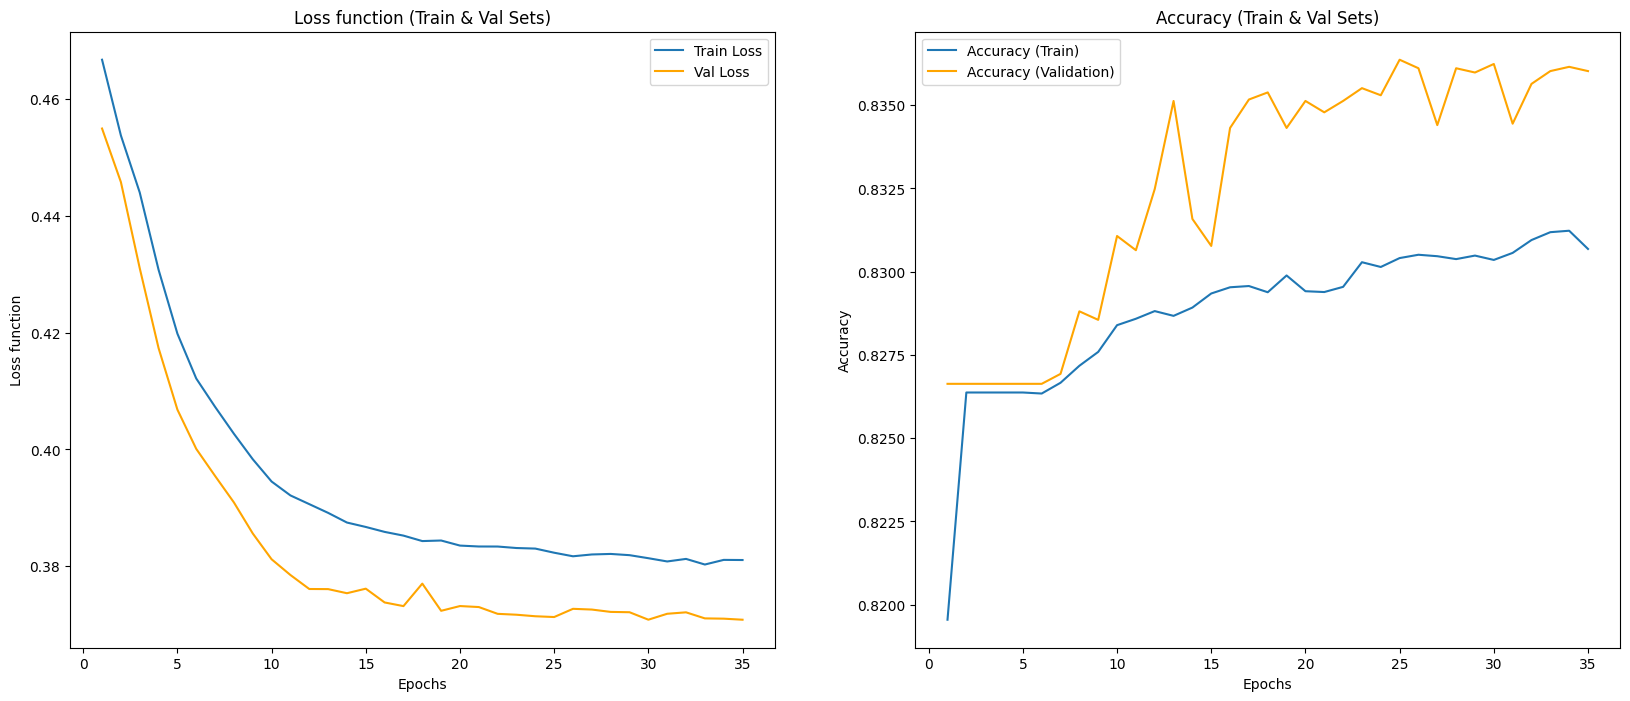

In [585]:
plt.figure(figsize=(20,8))
loss_function = binary_class_history.history['loss']
val_loss_function = binary_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = binary_class_history.history['accuracy']
val_acc = binary_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [586]:
probs = binary_classifier_4.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 2s 1ms/step


In [587]:
preds = (probs>0.5).astype(int)
preds

array([0, 0, 0, ..., 0, 0, 1])

In [588]:
recall = round(recall_score(truth, preds), 4)
precision = round(precision_score(truth, preds), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, preds), 4)
auc = round(roc_auc_score(truth, probs), 4)
print(recall,precision,weighted_accuracy,auc)

0.1066 0.605 0.5462 0.7977


Анализируя полученные метрики 4-х моделей, можно сделать вывод, Second Model оказался лучшим бинармным классификатором.

Построим ROC-кривую для данной модели:

In [589]:
probs_2 = binary_classifier_2.predict(X_test)[:,0]
truth = y_test

1422/1422 [==============================] - 2s 1ms/step


In [590]:
preds_2 = (probs_2>0.5).astype(int)
preds_2

array([0, 0, 0, ..., 0, 0, 1])

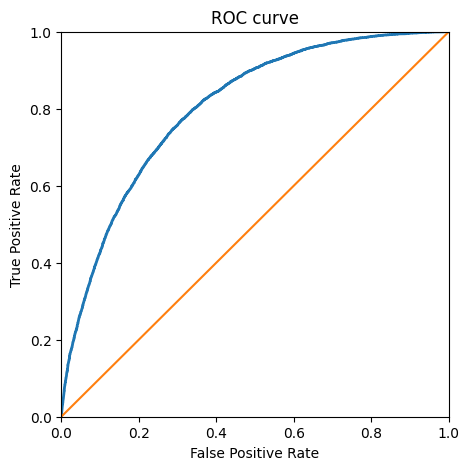

In [97]:
fpr, tpr, thresholds = roc_curve(truth, probs_2, pos_label=1)
lw = 2
plt.rcParams['figure.figsize']=(5,5)
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

### Вывод

Набор данных 'diabetes_012_health_indicators_BRFSS2015.csv' не содержал пропущенных значений, но в нем присутствовало несколько дубликатов, которые были удалены. В таргете начения "2" были преобразованы в "1".

Среди четырёх моделей бинарных классификаторов лучше всего сработала Second Model. В ней увеличено число слоёв по сравнению с Base Model, но не увеличено число нейронов на каждом слое.

Оценка качества бинарных классификаторов происходила по следующим метрикам: Recall, Precision, Weighted Accuracy и AUC.

### Многоклассовый классификатор

### Работа с данными

In [326]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [327]:
df.shape

(13393, 12)

In [328]:
df.isnull().sum()/df.shape[0]

age                        0.0
gender                     0.0
height_cm                  0.0
weight_kg                  0.0
body fat_%                 0.0
diastolic                  0.0
systolic                   0.0
gripForce                  0.0
sit and bend forward_cm    0.0
sit-ups counts             0.0
broad jump_cm              0.0
class                      0.0
dtype: float64

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [330]:
print(df['gender'].unique())
print(df['class'].unique())

['M' 'F']
['C' 'A' 'B' 'D']


In [331]:
df['gender'] = df['gender'].replace({'M' : 1, 'F' : 0})
df = df.rename(columns={'gender' : 'is_male'})
df['class'] = df['class'].replace({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3})

In [332]:
df1 = df.drop_duplicates()
df1.shape

(13392, 12)

In [333]:
df1.head()

,age,is_male,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


In [334]:
X = df1.drop(['class'],axis=1)
y = df1['class']

In [335]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [360]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=39)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.66, random_state=39)

In [361]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

# Создаем модели

# Base model

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:
1.   8 нейронов, функция активации - ReLU
2.   4 нейрона, функция активации - Softmax

In [338]:
multi_classifier = Sequential(
    [
        layers.Dense(8, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 8)                 96        
                                                                 
 dense_57 (Dense)            (None, 4)                 36        
                                                                 
Total params: 132 (528.00 Byte)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [339]:
multi_classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_r2:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [340]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
multi_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor='val_accuracy', verbose=1, mode='max',
                             save_best_only=True)

# List of callbacks
callbacks_list = [early_stop, checkpoint]


In [341]:
# Assuming multi_classifier is your model and callbacks_list is defined
multi_class_history = multi_classifier.fit(
    X_train,
    y_train,
    batch_size=10,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks_list,  # Make sure callbacks_list is defined earlier
    epochs=100
)

Epoch 1/100
908/938 [============================>.] - ETA: 0s - loss: 1.3669 - accuracy: 0.3377
Epoch 1: val_accuracy improved from -inf to 0.42826, saving model to body_weights-01-0.428.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.3653 - accuracy: 0.3407 - val_loss: 1.3105 - val_accuracy: 0.4283
Epoch 2/100
103/938 [==>...........................] - ETA: 1s - loss: 1.2907 - accuracy: 0.4553

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


927/938 [============================>.] - ETA: 0s - loss: 1.2500 - accuracy: 0.4690
Epoch 2: val_accuracy improved from 0.42826 to 0.49048, saving model to body_weights-02-0.490.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.2487 - accuracy: 0.4702 - val_loss: 1.2065 - val_accuracy: 0.4905
Epoch 3/100
935/938 [============================>.] - ETA: 0s - loss: 1.1507 - accuracy: 0.5073
Epoch 3: val_accuracy improved from 0.49048 to 0.50439, saving model to body_weights-03-0.504.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.1505 - accuracy: 0.5075 - val_loss: 1.1350 - val_accuracy: 0.5044
Epoch 4/100
920/938 [============================>.] - ETA: 0s - loss: 1.0837 - accuracy: 0.5328
Epoch 4: val_accuracy improved from 0.50439 to 0.52635, saving model to body_weights-04-0.526.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.0826 - accuracy: 0.5344 - val_loss: 1.0786 - val_accuracy: 0.5264
Epoch 5/100
920/938 [==========

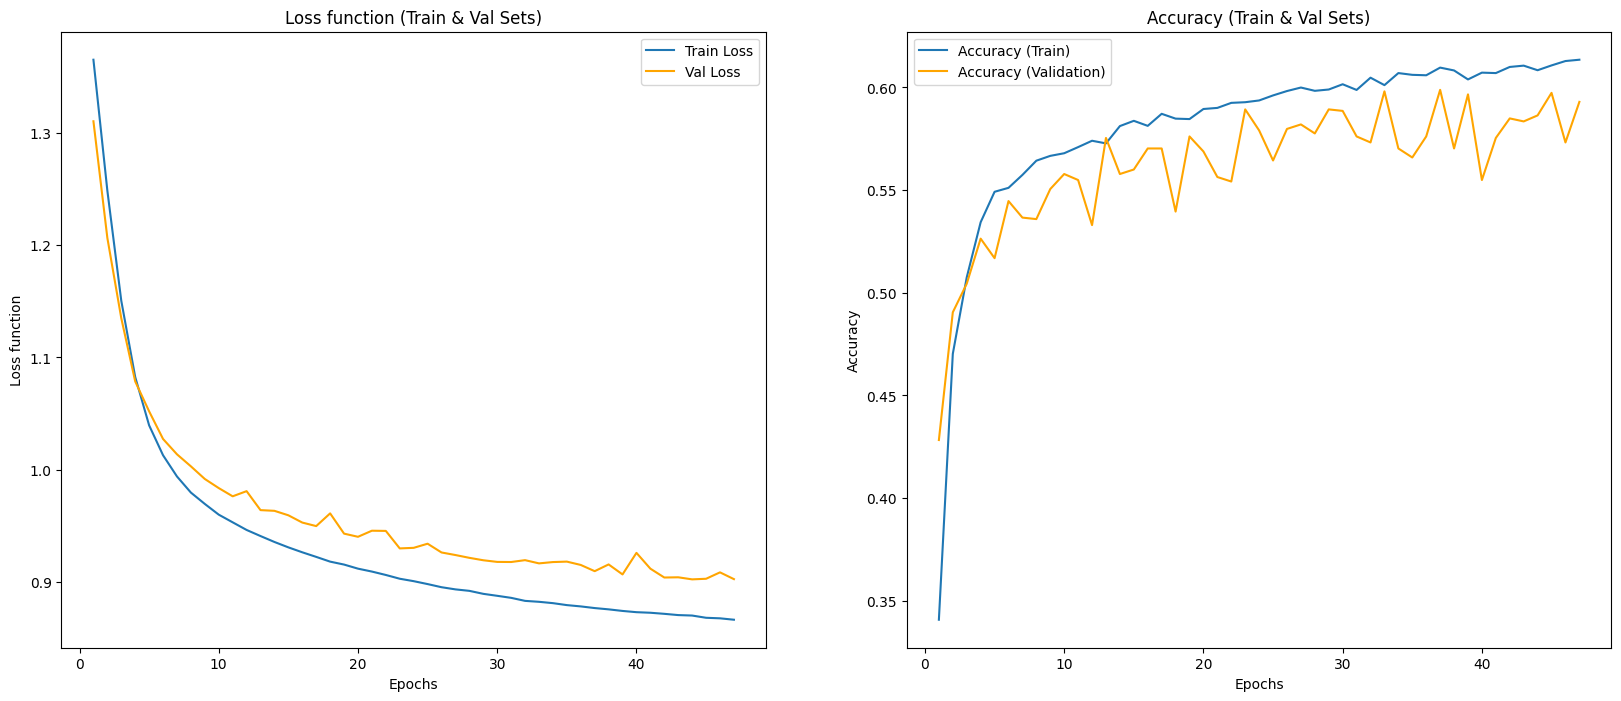

In [342]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [343]:
probs = multi_classifier.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 1ms/step


In [344]:
predicted = np.argmax(probs, axis=1)

In [345]:
df_metrics_multi = pd.DataFrame(columns=['model', 'recall', 'precision', 'weighted_accuracy', 'auc'])
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['base_model', recall, precision, weighted_accuracy, auc]

In [359]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6304,0.6265,0.6304,0.8589


# Second model

In [355]:
multi_classifier_2 = Sequential(
    [
        layers.Dense(8, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(8, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(8, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 8)                 96        
                                                                 
 dense_65 (Dense)            (None, 8)                 72        
                                                                 
 dense_66 (Dense)            (None, 8)                 72        
                                                                 
 dense_67 (Dense)            (None, 8)                 72        
                                                                 
 dense_68 (Dense)            (None, 8)                 72        
                                                                 
 dense_69 (Dense)            (None, 4)                 36        
                                                                 
Total params: 420 (1.64 KB)
Trainable params: 420 (1.

In [356]:
multi_classifier_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose =1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [362]:
multi_class_history = multi_classifier_2.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
929/938 [============================>.] - ETA: 0s - loss: 1.3923 - accuracy: 0.2447
Epoch 1: val_accuracy improved from -inf to 0.26720, saving model to body_weights-01-0.267.hdf5
938/938 [==============================] - 4s 3ms/step - loss: 1.3923 - accuracy: 0.2445 - val_loss: 1.3854 - val_accuracy: 0.2672
Epoch 2/100
 29/938 [..............................] - ETA: 3s - loss: 1.3864 - accuracy: 0.2655

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/938 [============================>.] - ETA: 0s - loss: 1.3863 - accuracy: 0.2556
Epoch 2: val_accuracy improved from 0.26720 to 0.27013, saving model to body_weights-02-0.270.hdf5
938/938 [==============================] - 3s 4ms/step - loss: 1.3863 - accuracy: 0.2557 - val_loss: 1.3831 - val_accuracy: 0.2701
Epoch 3/100
931/938 [============================>.] - ETA: 0s - loss: 1.3081 - accuracy: 0.3629
Epoch 3: val_accuracy improved from 0.27013 to 0.48243, saving model to body_weights-03-0.482.hdf5
938/938 [==============================] - 3s 3ms/step - loss: 1.3071 - accuracy: 0.3639 - val_loss: 1.1519 - val_accuracy: 0.4824
Epoch 4/100
921/938 [============================>.] - ETA: 0s - loss: 1.0241 - accuracy: 0.5369
Epoch 4: val_accuracy improved from 0.48243 to 0.51245, saving model to body_weights-04-0.512.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 1.0231 - accuracy: 0.5373 - val_loss: 1.0214 - val_accuracy: 0.5124
Epoch 5/100
932/938 [==========

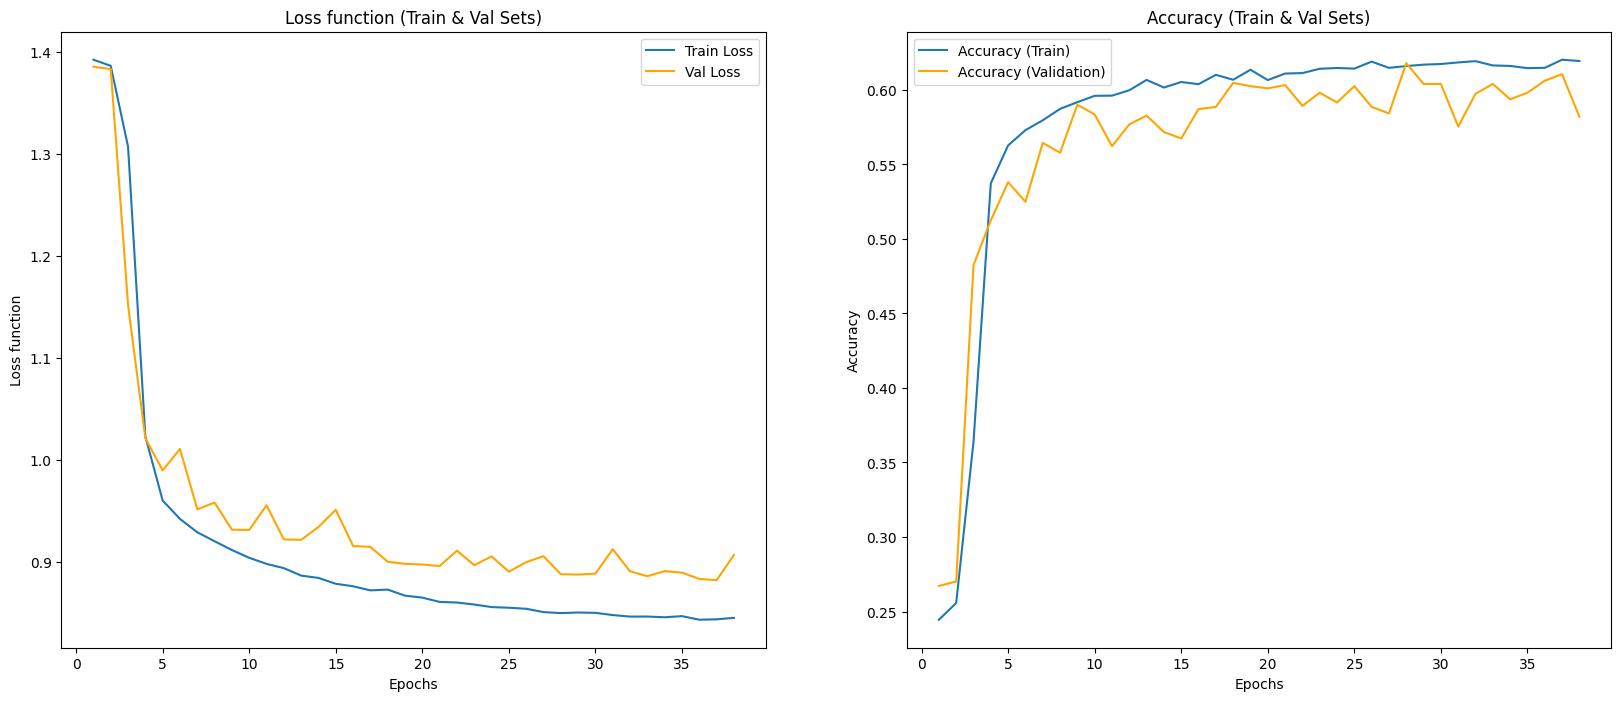

In [363]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [364]:
probs = multi_classifier_2.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 2ms/step


In [365]:
predicted = np.argmax(probs, axis=1)

In [366]:
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['second_model', recall, precision, weighted_accuracy, auc]

In [367]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6304,0.6265,0.6304,0.8589
1,second_model,0.6270,0.6421,0.6270,0.8570


# Third model

Увеличим количество нейронов на каждом слое, кроме двух последних:

1.   64 нейрона, функция активации - ReLU
2.   64 нейрона, функция активации - Sigmoid
3.   32 нейрона, функция активации - ReLU
4.   16 нейронов, функция активации - Sigmoid
5.   8 нейронов, функция активации - ReLU
6.   4 нейрона, функция активации - Softmax

In [368]:
multi_classifier_3 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 64)                768       
                                                                 
 dense_71 (Dense)            (None, 64)                4160      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 16)                528       
                                                                 
 dense_74 (Dense)            (None, 8)                 136       
                                                                 
 dense_75 (Dense)            (None, 4)                 36        
                                                                 
Total params: 7708 (30.11 KB)
Trainable params: 7708 

In [369]:
multi_classifier_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [370]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [371]:
multi_class_history = multi_classifier_3.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 50)

Epoch 1/50
88/94 [===========================>..] - ETA: 0s - loss: 1.3963 - accuracy: 0.2507
Epoch 1: val_accuracy improved from -inf to 0.28770, saving model to body_weights-01-0.288.hdf5
94/94 [==============================] - 3s 9ms/step - loss: 1.3957 - accuracy: 0.2513 - val_loss: 1.3851 - val_accuracy: 0.2877
Epoch 2/50
32/94 [=========>....................] - ETA: 0s - loss: 1.3860 - accuracy: 0.2578

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/94 [============================>.] - ETA: 0s - loss: 1.3847 - accuracy: 0.2638
Epoch 2: val_accuracy did not improve from 0.28770
94/94 [==============================] - 0s 5ms/step - loss: 1.3848 - accuracy: 0.2633 - val_loss: 1.3845 - val_accuracy: 0.2086
Epoch 3/50
84/94 [=========================>....] - ETA: 0s - loss: 1.3743 - accuracy: 0.2893
Epoch 3: val_accuracy improved from 0.28770 to 0.30893, saving model to body_weights-03-0.309.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 1.3729 - accuracy: 0.2876 - val_loss: 1.3556 - val_accuracy: 0.3089
Epoch 4/50
73/94 [======================>.......] - ETA: 0s - loss: 1.3178 - accuracy: 0.2711
Epoch 4: val_accuracy did not improve from 0.30893
94/94 [==============================] - 0s 3ms/step - loss: 1.3042 - accuracy: 0.2693 - val_loss: 1.2326 - val_accuracy: 0.2650
Epoch 5/50
92/94 [============================>.] - ETA: 0s - loss: 1.1888 - accuracy: 0.3598
Epoch 5: val_accuracy improved from 0.30893 to 

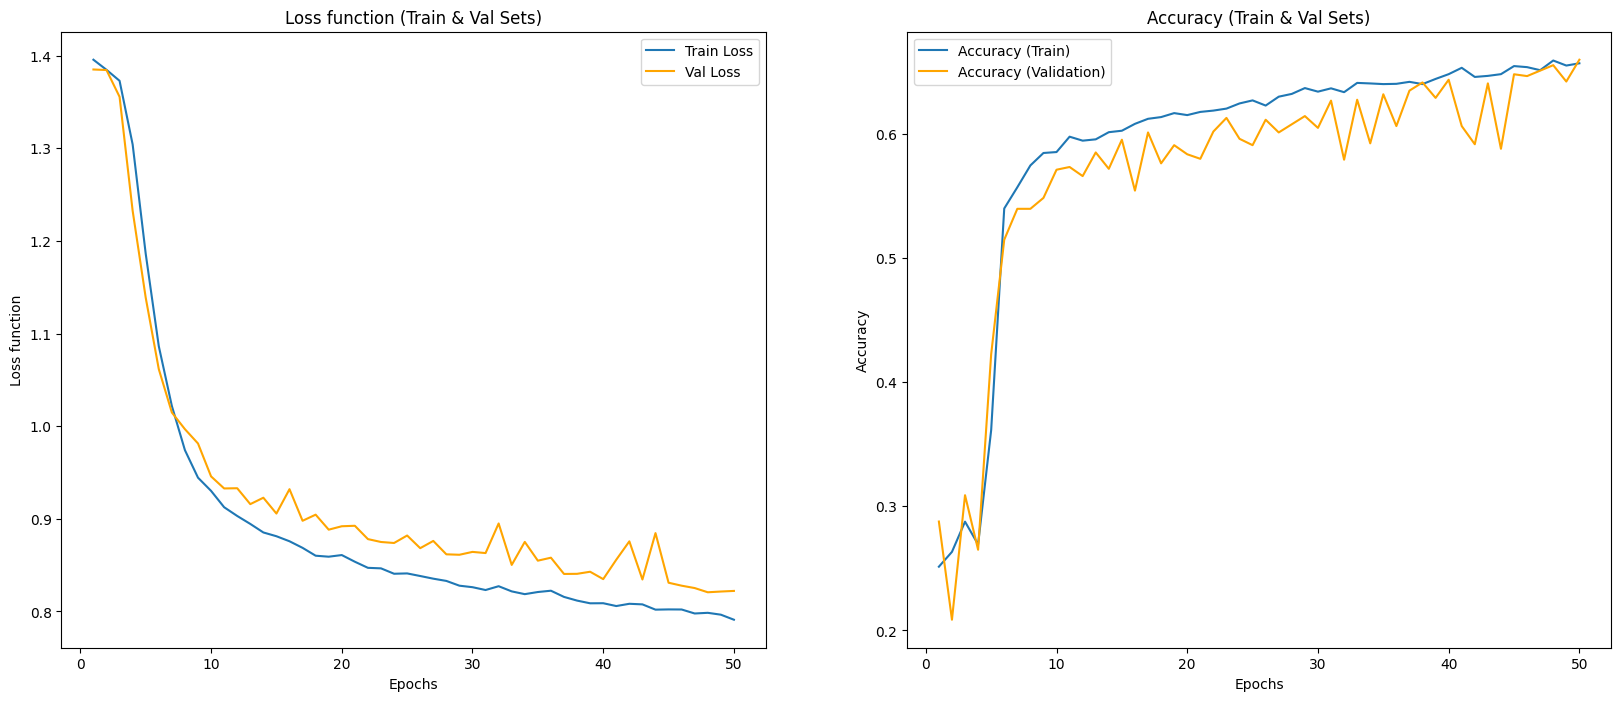

In [372]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [373]:
probs = multi_classifier_3.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 3ms/step


In [374]:
predicted = np.argmax(probs, axis=1)

In [375]:
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['third_model', recall, precision, weighted_accuracy, auc]

In [376]:
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6304,0.6265,0.6304,0.8589
1,second_model,0.6270,0.6421,0.6270,0.8570
2,third_model,0.6556,0.6684,0.6556,0.8776


# Fourth model

In [377]:
multi_classifier_4 = Sequential(
    [
        layers.Dense(128, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dropout(0.1),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(4, activation = 'softmax')
    ]
)
multi_classifier_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 128)               1536      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dense_79 (Dense)            (None, 16)                528       
                                                                 
 dense_80 (Dense)            (None, 8)               

In [378]:
multi_classifier_4.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop', metrics = 'accuracy')

In [379]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 1)
checkpoint = ModelCheckpoint('body_weights-{epoch:02d}-{val_accuracy:.3f}.hdf5',
                             monitor = 'val_accuracy', verbose = 1, mode = 'max',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [380]:
multi_class_history = multi_classifier_4.fit(X_train, y_train, batch_size = 100, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 100)

Epoch 1/100
91/94 [============================>.] - ETA: 0s - loss: 1.4017 - accuracy: 0.2502
Epoch 1: val_accuracy improved from -inf to 0.20937, saving model to body_weights-01-0.209.hdf5
94/94 [==============================] - 3s 11ms/step - loss: 1.4014 - accuracy: 0.2503 - val_loss: 1.3891 - val_accuracy: 0.2094
Epoch 2/100
26/94 [=======>......................] - ETA: 0s - loss: 1.3856 - accuracy: 0.2515

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/94 [===========================>..] - ETA: 0s - loss: 1.3856 - accuracy: 0.2567
Epoch 2: val_accuracy improved from 0.20937 to 0.26135, saving model to body_weights-02-0.261.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 1.3856 - accuracy: 0.2559 - val_loss: 1.3850 - val_accuracy: 0.2613
Epoch 3/100
89/94 [===========================>..] - ETA: 0s - loss: 1.3838 - accuracy: 0.2778
Epoch 3: val_accuracy improved from 0.26135 to 0.28404, saving model to body_weights-03-0.284.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 1.3839 - accuracy: 0.2765 - val_loss: 1.3813 - val_accuracy: 0.2840
Epoch 4/100
90/94 [===========================>..] - ETA: 0s - loss: 1.3771 - accuracy: 0.2966
Epoch 4: val_accuracy improved from 0.28404 to 0.31991, saving model to body_weights-04-0.320.hdf5
94/94 [==============================] - 0s 5ms/step - loss: 1.3768 - accuracy: 0.2962 - val_loss: 1.3680 - val_accuracy: 0.3199
Epoch 5/100
80/94 [========================

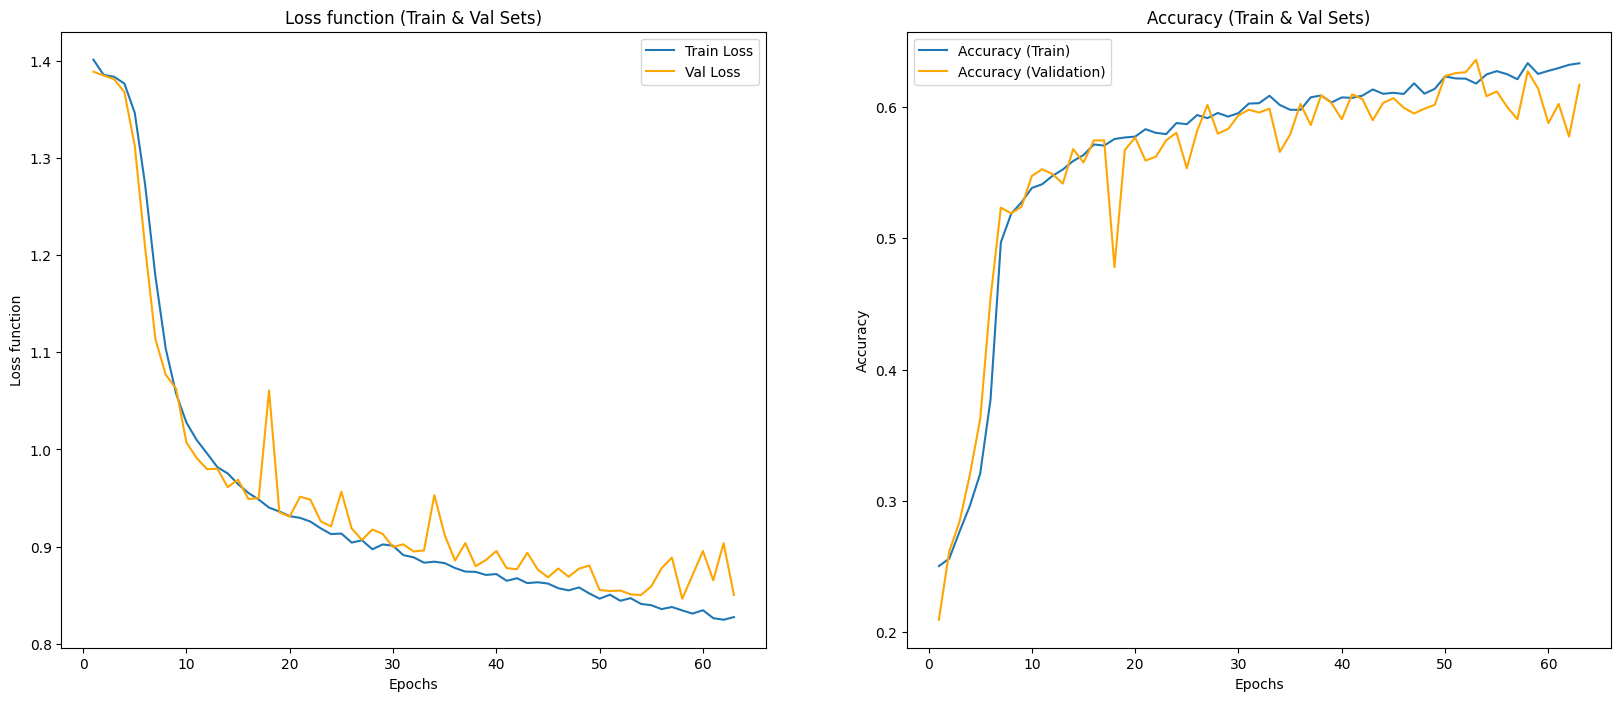

In [381]:
plt.figure(figsize=(20,8))
loss_function = multi_class_history.history['loss']
val_loss_function = multi_class_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

acc = multi_class_history.history['accuracy']
val_acc = multi_class_history.history['val_accuracy']
epochs = range(1,len(acc)+1)

plt.subplot(1, 2, 1)
plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy (Train & Val Sets)')
plt.plot(epochs,acc,label='Accuracy (Train)')
plt.plot(epochs,val_acc,color='orange',label='Accuracy (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [382]:
probs = multi_classifier_4.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 1s 4ms/step


In [383]:
predicted = np.argmax(probs, axis=1)

In [384]:
recall = round(recall_score(truth, predicted, average='macro'), 4)
precision = round(precision_score(truth, predicted, average='macro'), 4)
weighted_accuracy = round(balanced_accuracy_score(truth, predicted), 4)
auc = round(roc_auc_score(truth, probs, average='macro', multi_class='ovr'), 4)
df_metrics_multi.loc[len(df_metrics_multi.index)] = ['fourth_model', recall, precision, weighted_accuracy, auc]
df_metrics_multi

,model,recall,precision,weighted_accuracy,auc
0,base_model,0.6304,0.6265,0.6304,0.8589
1,second_model,0.6270,0.6421,0.6270,0.8570
2,third_model,0.6556,0.6684,0.6556,0.8776
3,fourth_model,0.6476,0.6543,0.6476,0.8723


Набор данных 'bodyPerformance.csv' не содержал пропущенных значений, но в нем присутствовал дубликат, который был удален. Значения в столбцах gender и class были закодированы.

Среди четырёх моделей многоклассовых классификаторов лучше всего сработала Third Model.

Оценка качества многоклассовых классификаторов происходила по следующим метрикам: Recall, Precision, Weighted Accuracy и AUC. Эти показатели у Third Model выше, чем у остальных моделей.

In [385]:
probs_4 = multi_classifier_4.predict(X_test)
truth = np.argmax(y_test, axis=1)

83/83 [==============================] - 0s 3ms/step


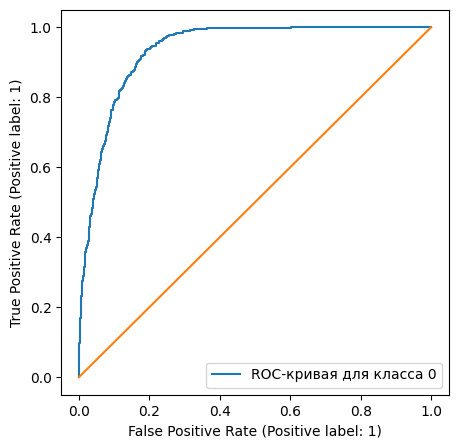

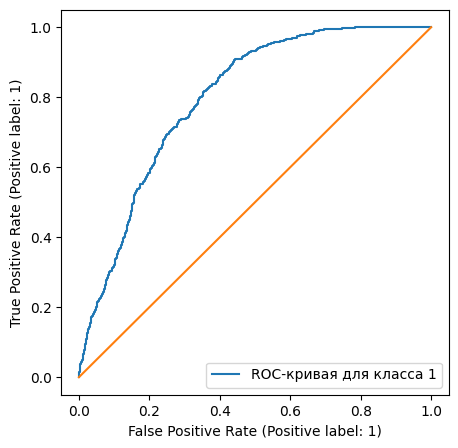

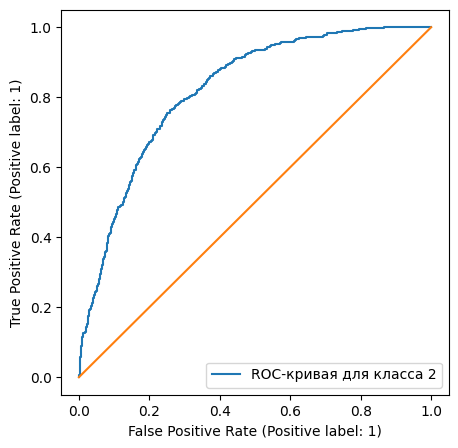

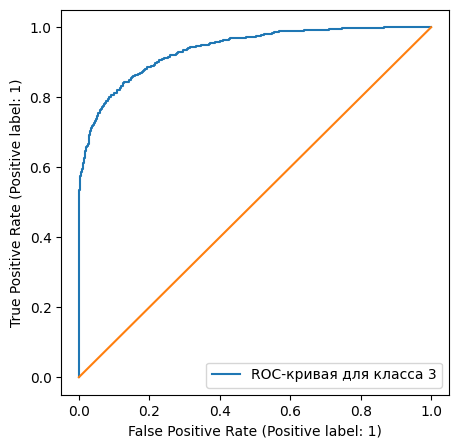

In [386]:
for i in range(0, 4):
    RocCurveDisplay.from_predictions(
        y_test[:, i],
        probs_4[:, i],
        label = f"ROC-кривая для класса {i}"
    )
    x = np.linspace(0, 1, 10)
    y = x
    plt.plot(x,y)
plt.show()

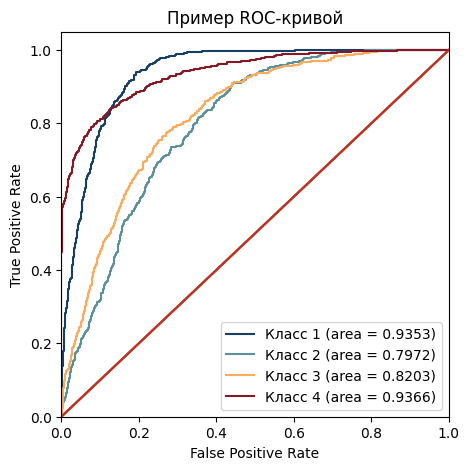

In [388]:
colors = ['#173f61', '#5b8f9a', '#faab5c', '#841826']
for i in range (0, 4):
    fpr, tpr, treshold = roc_curve(y_test[:,i], probs_4[:,i])
    auc = round(roc_auc_score(y_test[:,i], probs_4[:,i]), 4)
    plt.plot(fpr, tpr, label=f"Класс {i+1} (area = {auc})", color = colors[i])
    plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

### Задание №3
### Регрессор

### Работа с данными

In [471]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_2019_public.csv', encoding = "windows-1251")
df.head()

<ipython-input-471-7e5f673c9975>:1: DtypeWarning: Columns (30,56,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_2019_public.csv', encoding = "windows-1251")


,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
0,5,10,26,16.793,17,181.998,620.979,621,368,38606,...,-2,30110,2,120.893,121,4,0,1,1,1310.220
1,1,1,1,48.901,49,184.459,629.389,629,582,40248,...,2,7933,-2,242.746,243,2,0,1,-2,915.664
2,1,3,7,101.048,101,1063.022,3627.013,3627,425,40196,...,-2,6440,5,158.797,159,7,0,1,5,1670.534
3,1,1,1,0,0,0.000,0.000,0,616,36136,...,2,13884,5,85.138,85,5,0,1,5,346.468
4,1,4,10,45.132,45,274.530,936.677,937,685,74100,...,3,14204,6,151.319,151,6,0,1,5,920.454


In [472]:
df.shape

(10875, 121)

In [473]:
#Пропусков нет
df.isnull().sum()/df.shape[0]

Climate_Region_Pub    0.0
DIVISION              0.0
REPORTABLE_DOMAIN     0.0
DOLELCOL              0.0
TOTALDOLCOL           0.0
                     ... 
HEATROOM              0.0
WDWATER               0.0
UGWARM                0.0
DRYRFUEL              0.0
KWHRFG                0.0
Length: 121, dtype: float64

In [474]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10875 entries, 0 to 10874
Data columns (total 121 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    Climate_Region_Pub  10875 non-null  int64  
 1    DIVISION            10875 non-null  int64  
 2    REPORTABLE_DOMAIN   10875 non-null  int64  
 3    DOLELCOL            10875 non-null  object 
 4    TOTALDOLCOL         10875 non-null  int64  
 5    KWHCOL              10875 non-null  float64
 6    BTUELCOL            10875 non-null  float64
 7    TOTALBTUCOL         10875 non-null  int64  
 8    TOTALDOLSPH         10875 non-null  int64  
 9    TOTALBTUSPH         10875 non-null  int64  
 10   CELLAR              10875 non-null  int64  
 11   NWEIGHT             10875 non-null  float64
 12   TOTHSQFT            10875 non-null  int64  
 13   HEATHOME            10875 non-null  int64  
 14   NUMPC               10875 non-null  int64  
 15   DOLLAREL            10875 non-null

In [475]:
types = df.dtypes
types = types.loc[types == "object"]

In [476]:
for i in types.index:
    print(i)
    print(df[i].unique())

DOLELCOL
['16.793' '48.901' '101.048' ... '13.005' '97.67' '12.834']
DOLFOSPH
[0.0 1661.0 926.155 847.0 875.0 1106.053 3570.293 779.0 1024.271 2279.0
 1484.04 1520.569 923.0 1094.0 814.629 807.0 712.0 797.359 1089.0 1232.764
 1258.0 1442.609 915.0 1078.608 1898.063 1439.726 1731.774 791.0 1638.045
 952.0 2707.975 1797.946 630.42 1667.645 2381.0 949.0 588.0 932.398
 1390.096 1567.971 1636.683 815.064 1458.0 866.613 1356.052 963.0 778.0
 2207.733 831.0 2131.35 1402.996 971.153 429.135 1672.705 1076.78 1351.0
 2635.615 979.0 704.0 1117.026 1343.804 1043.0 2324.0 2139.038 1468.0
 2374.0 1288.976 753.0 1681.83 831.073 788.0 955.0 1332.046 1980.862 989.0
 1650.223 1759.0 1335.196 761.0 854.0 1315.072 1548.055 1311.0 1376.0
 2404.023 1957.627 3300.179 741.0 865.0 686.0 1710.288 1048.763 132.6
 832.0 1039.0 1069.0 545.77 1020.717 781.0 1771.494 766.0 1685.128
 1123.646 2003.385 3093.119 763.0 730.0 945.0 2222.931 2321.541 1217.755
 916.0 1327.944 1023.79 1559.25 1067.426 1940.981 1044.0 1090.0

Столбцы типа object в основном состоят из числовых значений. Скорее всего, там присутствуют выбросы. Переведем в float все возможные значениях в данных столбцах. Если так сделать нельзя - значение удаляем:

In [477]:
def convert_to_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [478]:
for i in types.index:
    df[i] = df[i].apply(lambda x: convert_to_float(x))
    print(i)
    print(df[i].isnull().sum())

DOLELCOL
70
DOLFOSPH
1
DOLELSPH
4
DOLNGWTH
2
CUFEETNGOTH
12
KWHOTH
1
CUFEETNGWTH
3
DOLELRFG
1


Удаляем строки с пропущенными значениями:

In [479]:
df.dropna(inplace=True)
df.shape

(10785, 121)

In [480]:
#Дубликатов нет
df = df.drop_duplicates()
df.shape

(10785, 121)

In [481]:
df.describe()

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,LGT1EE,TOTALBTUWTH,ROOFTYPE,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,DRYRFUEL,KWHRFG
count,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,...,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000,10785.000000
mean,2.608067,5.376263,14.798146,203.750405,203.749652,1693.624306,5778.645776,5778.642281,561.049235,36878.418730,...,0.818173,16344.560779,3.673621,154.725129,154.728234,5.349096,0.000834,0.500788,2.984979,1246.633642
std,1.347541,2.859324,8.199397,311.318456,311.321580,2485.590453,8480.833423,8480.830656,505.514181,35826.928857,...,2.350035,13755.839203,2.773690,107.181736,107.184538,2.639938,0.028877,0.500023,2.840688,778.412482
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-9.000000,0.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000
25%,1.000000,3.000000,8.000000,19.413000,19.000000,150.993000,515.182000,515.000000,222.000000,8713.000000,...,0.000000,7718.000000,2.000000,86.393000,86.000000,4.000000,0.000000,0.000000,1.000000,725.791000
50%,3.000000,5.000000,16.000000,90.775000,91.000000,763.090000,2603.690000,2604.000000,430.000000,27209.000000,...,0.000000,12778.000000,5.000000,127.090000,127.000000,5.000000,0.000000,1.000000,5.000000,1049.151000
75%,4.000000,7.000000,21.000000,264.527000,265.000000,2303.045000,7858.013000,7858.000000,762.000000,55719.000000,...,2.000000,21193.000000,5.000000,192.992000,193.000000,7.000000,0.000000,1.000000,5.000000,1561.557000
max,5.000000,10.000000,27.000000,7729.265000,7729.000000,60995.431000,208116.552000,208117.000000,9264.000000,548711.000000,...,40.000000,284130.000000,8.000000,2490.046000,2490.000000,23.000000,1.000000,1.000000,5.000000,11069.027000


В некоторых столбцах присутствуют выбросы в виде отрицательных значений. Удалим такие значения:

In [482]:
for i in df.columns:
    df.loc[df[i]<0, i] = np.nan
    if (df[i].isnull().sum()/df.shape[0])>0:
        print(i)
        print(df[i].isnull().sum()/df.shape[0])

CELLAR
0.20407974038015764
TEMPHOME
0.03801576263328697
NUMTHERM
0.15159944367176634
CONCRETE
0.20407974038015764
BEDROOMS
0.0181733889661567
FUELHEAT
0.03801576263328697
COOLTYPE
0.17923041261010664
DOOR1SUM
9.27213722763097e-05
EQUIPM
0.03801576263328697
STORIES
0.23532684283727398
FUELH2O
0.0028743625405656
TEMPGONE
0.03801576263328697
LGT1EE
0.16430227167362077
ROOFTYPE
0.15957348168752897
HEATROOM
0.03801576263328697
DRYRFUEL
0.19499304589707928


Появились столбцы с пропущенными значениями. Удалим столбцы с процентом NaN больше 5%. В остальных удалим строки с пропущенными значениям:

In [483]:
for i in df.columns:
    if (df[i].isnull().sum()/df.shape[0])>=0.05:
        df = df.drop(i, axis=1)

In [484]:
df.shape

(10785, 113)

In [485]:
df.dropna(inplace=True)

In [486]:
#Пропущенных значений нет
df.isnull().sum().sum()

0

In [487]:
df.head()

,Climate_Region_Pub,DIVISION,REPORTABLE_DOMAIN,DOLELCOL,TOTALDOLCOL,KWHCOL,BTUELCOL,TOTALBTUCOL,TOTALDOLSPH,TOTALBTUSPH,...,UGWATER,SDESCENT,TEMPGONE,TOTALBTUWTH,DOLELRFG,TOTALDOLRFG,HEATROOM,WDWATER,UGWARM,KWHRFG
0,5.0,10.0,26.0,16.793,17.0,181.998,620.979,621.0,368.0,38606.0,...,1.0,0.0,70.0,30110.0,120.893,121.0,4.0,0.0,1.0,1310.220
1,1.0,1.0,1.0,48.901,49.0,184.459,629.389,629.0,582.0,40248.0,...,1.0,0.0,60.0,7933.0,242.746,243.0,2.0,0.0,1.0,915.664
2,1.0,3.0,7.0,101.048,101.0,1063.022,3627.013,3627.0,425.0,40196.0,...,0.0,0.0,55.0,6440.0,158.797,159.0,7.0,0.0,1.0,1670.534
3,1.0,1.0,1.0,0.000,0.0,0.000,0.000,0.0,616.0,36136.0,...,1.0,0.0,70.0,13884.0,85.138,85.0,5.0,0.0,1.0,346.468
4,1.0,4.0,10.0,45.132,45.0,274.530,936.677,937.0,685.0,74100.0,...,1.0,0.0,66.0,14204.0,151.319,151.0,6.0,0.0,1.0,920.454


In [488]:
X = df.drop(['TOTALDOL'],axis=1)
y = df['TOTALDOL']

In [489]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Разделим датасет на три части: тренировочную (70%), тестовую (20%) и валидационную (10%).

In [490]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=39)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.66, random_state=39)

### Создание моделей
#### Base Model

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:
1. 16 нейронов, функция активации - ReLU
2. 1 нейрон

In [491]:
regressor = Sequential(
    [
        layers.Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(1)
    ]
)
regressor.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 16)                1808      
                                                                 
 dense_127 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1825 (7.13 KB)
Trainable params: 1825 (7.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [492]:
regressor.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [493]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose =1)
checkpoint = ModelCheckpoint('household-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [494]:
regressor_history = regressor.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 200)

Epoch 1/200
711/714 [============================>.] - ETA: 0s - loss: 5623436.0000
Epoch 1: val_loss improved from inf to 4844486.00000, saving model to household-01-4844486.000.hdf5
714/714 [==============================] - 2s 2ms/step - loss: 5615774.0000 - val_loss: 4844486.0000
Epoch 2/200
 71/714 [=>............................] - ETA: 1s - loss: 4612846.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


700/714 [============================>.] - ETA: 0s - loss: 4511604.5000
Epoch 2: val_loss improved from 4844486.00000 to 3454123.25000, saving model to household-02-3454123.250.hdf5
714/714 [==============================] - 2s 2ms/step - loss: 4483901.0000 - val_loss: 3454123.2500
Epoch 3/200
691/714 [============================>.] - ETA: 0s - loss: 3034141.2500
Epoch 3: val_loss improved from 3454123.25000 to 2118703.25000, saving model to household-03-2118703.250.hdf5
714/714 [==============================] - 2s 3ms/step - loss: 3011524.7500 - val_loss: 2118703.2500
Epoch 4/200
699/714 [============================>.] - ETA: 0s - loss: 1869584.8750
Epoch 4: val_loss improved from 2118703.25000 to 1301448.37500, saving model to household-04-1301448.375.hdf5
714/714 [==============================] - 2s 3ms/step - loss: 1859566.6250 - val_loss: 1301448.3750
Epoch 5/200
704/714 [============================>.] - ETA: 0s - loss: 1264856.6250
Epoch 5: val_loss improved from 1301448.375

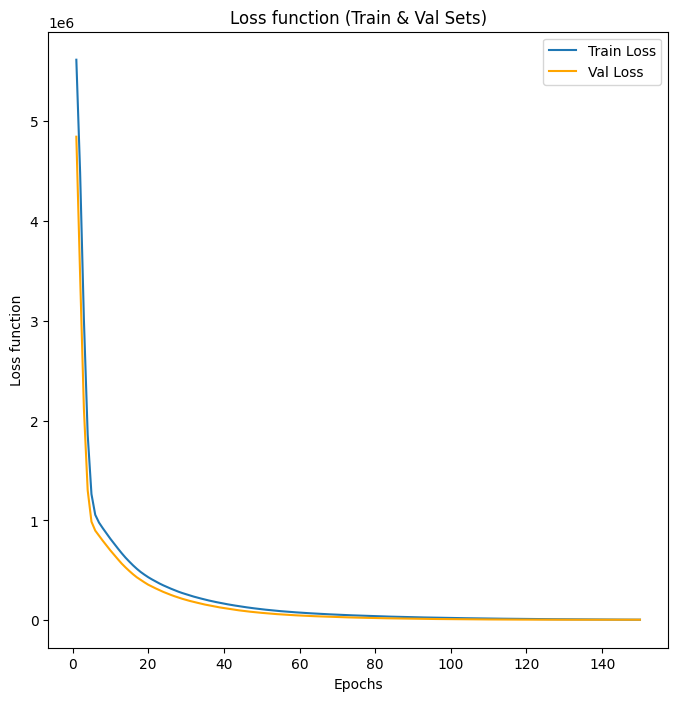

In [495]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [496]:
probs = regressor.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 2ms/step


In [532]:
df_metrics_regress = pd.DataFrame(columns=['model', 'mse', 'mae', 'r2'])
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['base_model', mse, mae, r2]

In [533]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,3514.233,15.515,0.99734


#### Second Model

Во второй модели увеличим количество слоёв, не увиличивая число нейронов и чередуя функции активации:
1. 16 нейронов, функция активации - ReLU
2. 16 нейронов, функция активации - Sigmoid
3. 16 нейронов, функция активации - SeLU
4. 16 нейронов, функция активации - Sigmoid
5. 16 нейронов, функция активации - ReLU
6. 1 нейрон

In [499]:
regressor_2 = Sequential(
    [
        layers.Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(16, activation = 'selu'),
        layers.Dense(16, activation = 'sigmoid'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ]
)
regressor_2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 16)                1808      
                                                                 
 dense_129 (Dense)           (None, 16)                272       
                                                                 
 dense_130 (Dense)           (None, 16)                272       
                                                                 
 dense_131 (Dense)           (None, 16)                272       
                                                                 
 dense_132 (Dense)           (None, 16)                272       
                                                                 
 dense_133 (Dense)           (None, 1)                 17        
                                                                 
Total params: 2913 (11.38 KB)
Trainable params: 2913 

In [500]:
regressor_2.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [501]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose =1)
checkpoint = ModelCheckpoint('household_2-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [502]:
regressor_history = regressor_2.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 200)

Epoch 1/200
693/714 [============================>.] - ETA: 0s - loss: 5689055.0000
Epoch 1: val_loss improved from inf to 4986209.50000, saving model to household_2-01-4986209.500.hdf5
714/714 [==============================] - 3s 3ms/step - loss: 5668213.0000 - val_loss: 4986209.5000
Epoch 2/200
 81/714 [==>...........................] - ETA: 1s - loss: 5160173.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


696/714 [============================>.] - ETA: 0s - loss: 4806521.0000
Epoch 2: val_loss improved from 4986209.50000 to 3872618.50000, saving model to household_2-02-3872618.500.hdf5
714/714 [==============================] - 2s 2ms/step - loss: 4784414.0000 - val_loss: 3872618.5000
Epoch 3/200
709/714 [============================>.] - ETA: 0s - loss: 3559342.2500
Epoch 3: val_loss improved from 3872618.50000 to 2694974.75000, saving model to household_2-03-2694974.750.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 3559778.2500 - val_loss: 2694974.7500
Epoch 4/200
705/714 [============================>.] - ETA: 0s - loss: 2479349.0000
Epoch 4: val_loss improved from 2694974.75000 to 1838377.25000, saving model to household_2-04-1838377.250.hdf5
714/714 [==============================] - 1s 2ms/step - loss: 2478945.2500 - val_loss: 1838377.2500
Epoch 5/200
706/714 [============================>.] - ETA: 0s - loss: 1803793.8750
Epoch 5: val_loss improved from 18383

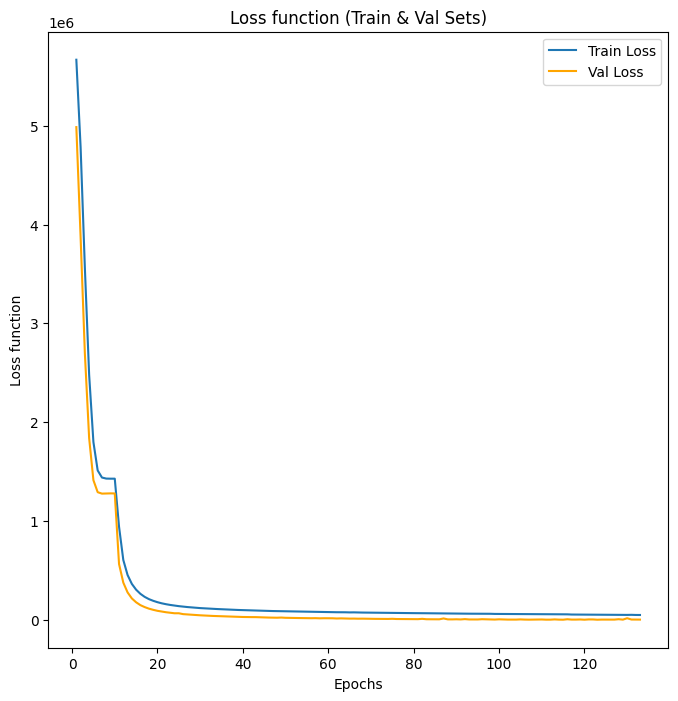

In [503]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [504]:
probs = regressor_2.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 1ms/step


In [534]:
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['second_model', mse, mae, r2]

In [535]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,3514.233,15.515,0.99734
1,second_model,3514.233,15.515,0.99734


#### Third Model

Увеличим количество нейронов на каждом слое, кроме двух последних:
1. 64 нейрона, функция активации - ReLU
2. 64 нейрона, функция активации - Sigmoid
3. 32 нейрона, функция активации - SeLU
4. 32 нейронов, функция активации - Sigmoid
5. 16 нейронов, функция активации - ReLU
6. 1 нейрон

In [523]:
regressor_3 = Sequential(
    [
        layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dense(32, activation = 'selu'),
        layers.Dense(32, activation = 'sigmoid'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ]
)
regressor_3.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 64)                7232      
                                                                 
 dense_147 (Dense)           (None, 64)                4160      
                                                                 
 dense_148 (Dense)           (None, 32)                2080      
                                                                 
 dense_149 (Dense)           (None, 32)                1056      
                                                                 
 dense_150 (Dense)           (None, 16)                528       
                                                                 
 dense_151 (Dense)           (None, 1)                 17        
                                                                 
Total params: 15073 (58.88 KB)
Trainable params: 1507

In [524]:
regressor_3.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [525]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)
checkpoint = ModelCheckpoint('household_3-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [527]:
regressor_history = regressor_3.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 160)

Epoch 1/160
709/714 [============================>.] - ETA: 0s - loss: 2000140.8750
Epoch 1: val_loss improved from 2423597.50000 to 1389742.37500, saving model to household_3-01-1389742.375.hdf5
714/714 [==============================] - 3s 4ms/step - loss: 2005905.5000 - val_loss: 1389742.3750
Epoch 2/160
703/714 [============================>.] - ETA: 0s - loss: 1454742.8750
Epoch 2: val_loss improved from 1389742.37500 to 1277431.12500, saving model to household_3-02-1277431.125.hdf5
714/714 [==============================] - 5s 7ms/step - loss: 1469336.1250 - val_loss: 1277431.1250
Epoch 3/160
705/714 [============================>.] - ETA: 0s - loss: 1433364.0000
Epoch 3: val_loss did not improve from 1277431.12500
714/714 [==============================] - 2s 2ms/step - loss: 1429507.6250 - val_loss: 1278156.8750
Epoch 4/160
695/714 [============================>.] - ETA: 0s - loss: 1147227.5000
Epoch 4: val_loss improved from 1277431.12500 to 561745.87500, saving model to house

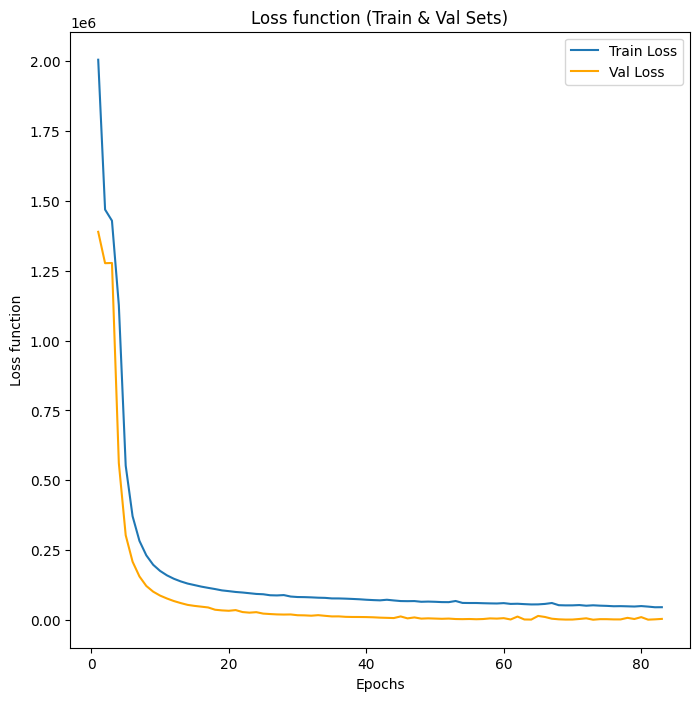

In [528]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [536]:
probs = regressor_3.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 1ms/step


In [537]:
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['third_model', mse, mae, r2]

In [538]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,3514.233,15.515,0.99734
1,second_model,3514.233,15.515,0.99734
2,third_model,3514.233,15.515,0.99734


#### Fourth Model

Добавим Dropout(0.1) после нескольких первых слоёв. В первом слое увеличим количество нейронов до 128:

In [539]:
regressor_4 = Sequential(
    [
        layers.Dense(128, activation = 'relu', input_dim = X_train.shape[1]),
        layers.Dropout(0.1),
        layers.Dense(64, activation = 'sigmoid'),
        layers.Dropout(0.1),
        layers.Dense(32, activation = 'selu'),
        layers.Dense(32, activation = 'sigmoid'),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(1)
    ]
)
regressor_4.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 128)               14464     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_153 (Dense)           (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_154 (Dense)           (None, 32)                2080      
                                                                 
 dense_155 (Dense)           (None, 32)                1056      
                                                                 
 dense_156 (Dense)           (None, 16)              

Изменим процедуру оптимизации на RMSprop:

In [540]:
regressor_4.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [541]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)
checkpoint = ModelCheckpoint('household_4-{epoch:02d}-{val_loss:.3f}.hdf5',
                             monitor = 'val_loss', verbose = 1, mode = 'min',
                             save_best_only = True)
callbacks_list = [early_stop,checkpoint]

In [542]:
regressor_history = regressor_4.fit(X_train, y_train, batch_size = 10, validation_data = (X_valid, y_valid),
                                        callbacks = callbacks_list, epochs = 200)

Epoch 1/200
703/714 [============================>.] - ETA: 0s - loss: 5560545.0000
Epoch 1: val_loss improved from inf to 4793591.00000, saving model to household_4-01-4793591.000.hdf5
714/714 [==============================] - 4s 3ms/step - loss: 5589952.5000 - val_loss: 4793591.0000
Epoch 2/200
 31/714 [>.............................] - ETA: 2s - loss: 5279017.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


711/714 [============================>.] - ETA: 0s - loss: 4445886.5000
Epoch 2: val_loss improved from 4793591.00000 to 3405106.00000, saving model to household_4-02-3405106.000.hdf5
714/714 [==============================] - 3s 4ms/step - loss: 4439270.0000 - val_loss: 3405106.0000
Epoch 3/200
704/714 [============================>.] - ETA: 0s - loss: 3030107.2500
Epoch 3: val_loss improved from 3405106.00000 to 2158403.75000, saving model to household_4-03-2158403.750.hdf5
714/714 [==============================] - 2s 3ms/step - loss: 3014006.7500 - val_loss: 2158403.7500
Epoch 4/200
713/714 [============================>.] - ETA: 0s - loss: 1995368.2500
Epoch 4: val_loss improved from 2158403.75000 to 1487415.12500, saving model to household_4-04-1487415.125.hdf5
714/714 [==============================] - 2s 2ms/step - loss: 1994055.7500 - val_loss: 1487415.1250
Epoch 5/200
688/714 [===========================>..] - ETA: 0s - loss: 1549671.6250
Epoch 5: val_loss improved from 14874

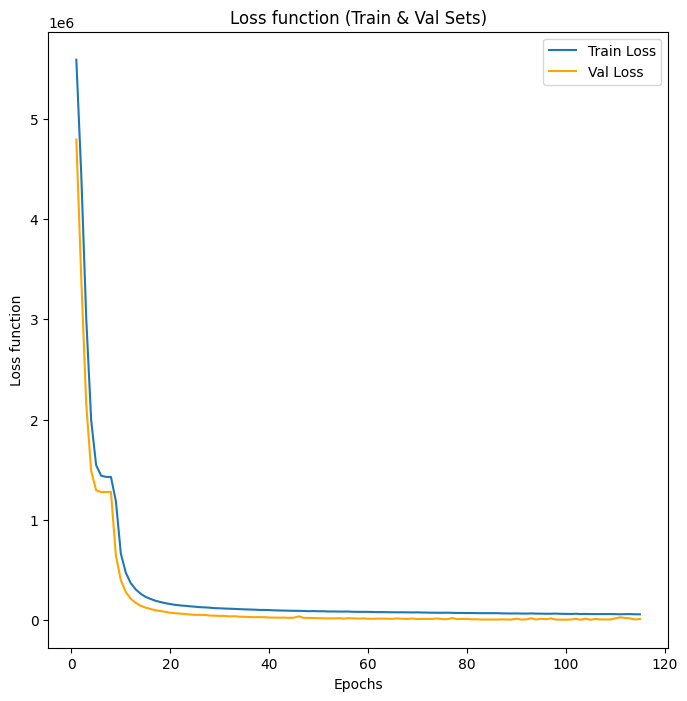

In [543]:
plt.figure(figsize=(8,8))
loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

In [544]:
probs = regressor_4.predict(X_test)
truth = y_test

64/64 [==============================] - 0s 2ms/step


In [545]:
mse = round(mean_squared_error(probs, truth), 3)
mae = round(mean_absolute_error(probs, truth), 3)
r2 = round(r2_score(probs, truth), 5)
df_metrics_regress.loc[len(df_metrics_regress.index)] = ['fourth_model', mse, mae, r2]

In [546]:
df_metrics_regress

,model,mse,mae,r2
0,base_model,3514.233,15.515,0.99734
1,second_model,3514.233,15.515,0.99734
2,third_model,3514.233,15.515,0.99734
3,fourth_model,5792.429,43.333,0.99531


Анализируя полученные метрики 4-х моделей, можно сделать вывод, что наилучшим регрессором является Third Model.

### Вывод

Набор данных 'DS_2019_public.csv' изначально не содержал пропущенных значений. Столбцы типа object состояли из числовых значений, поэтому мы перевели данные в них в float, а при невозможности такого преобразования удаляли строки с выбросами. В некоторых столбцах были выбросы в виде отрицательных значений. После удаления этих значений появились столбцы с NaN. Cтолбцы с процентом NaN больше 5% мы удалили, а в остальных столбцах удалили строки с пропущенными значениям. Дубликатов нет.

Среди четырёх моделей регрессоров лучше всего сработала Third Model.